In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

2025-02-11 11:58:31.211002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [3]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [4]:
datapath = "./data/SisFall.csv"

df = pd.read_csv(datapath, index_col=0)
df.head(10)

,ADXL_x,ADXL_y,ADXL_z,ITG_x,ITG_y,ITG_z,MMA_x,MMA_y,MMA_z,subject,activity,trial
NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,SA01,D01,R01
0.0,17.0,-179.0,-99.0,-18.0,-504.0,-352.0,76.0,-697.0,-279.0,SA01,D01,R01
1.0,15.0,-174.0,-90.0,-53.0,-568.0,-306.0,48.0,-675.0,-254.0,SA01,D01,R01
2.0,1.0,-176.0,-81.0,-84.0,-613.0,-271.0,-2.0,-668.0,-221.0,SA01,D01,R01
3.0,-10.0,-180.0,-77.0,-104.0,-647.0,-227.0,-34.0,-697.0,-175.0,SA01,D01,R01
4.0,-21.0,-191.0,-63.0,-128.0,-675.0,-191.0,-74.0,-741.0,-133.0,SA01,D01,R01
5.0,-37.0,-225.0,-59.0,-146.0,-700.0,-159.0,-110.0,-840.0,-103.0,SA01,D01,R01
6.0,-36.0,-243.0,-46.0,-166.0,-722.0,-131.0,-147.0,-948.0,-75.0,SA01,D01,R01
7.0,-44.0,-271.0,-38.0,-190.0,-738.0,-107.0,-171.0,-1073.0,-38.0,SA01,D01,R01
8.0,-51.0,-312.0,-33.0,-210.0,-752.0,-90.0,-200.0,-1191.0,3.0,SA01,D01,R01


In [5]:
print (df.columns)
print (set(df['subject']))
features = df.copy()

# dnum = 200
# fnum = 365

Index(['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'MMA_x',
       'MMA_y', 'MMA_z', 'subject', 'activity', 'trial'],
      dtype='object')
{'SA19', 'SE01', 'SE12', 'SE07', 'SA06', 'SA04', 'SA20', 'SE14', 'SE15', 'SA18', 'SE06', 'SE09', 'SE05', 'SA01', 'SE02', 'SA11', 'SA16', 'SA02', 'SA05', 'SA08', 'SA15', 'SE13', 'SA12', 'SA10', 'SE04', 'SA23', 'SA03', 'SE08', 'SA07', 'SA17', 'SA14', 'SE10', 'SA09', 'SA21', 'SA13', 'SE11', 'SE03', 'SA22'}


In [6]:
D01 = features[(features['activity']=='D01') & (features['subject']=='SA01')].copy()
D02 = features[(features['activity']=='D02') & (features['subject']=='SA01')].copy()
D03 = features[(features['activity']=='D03') & (features['subject']=='SA01')].copy()
D04 = features[(features['activity']=='D04') & (features['subject']=='SA01')].copy()
D05 = features[(features['activity']=='D05') & (features['subject']=='SA01')].copy()
D06 = features[(features['activity']=='D06') & (features['subject']=='SA01')].copy()
D07 = features[(features['activity']=='D07') & (features['subject']=='SA01')].copy()
D08 = features[(features['activity']=='D08') & (features['subject']=='SA01')].copy()
D09 = features[(features['activity']=='D09') & (features['subject']=='SA01')].copy()
D10 = features[(features['activity']=='D10') & (features['subject']=='SA01')].copy()
D11 = features[(features['activity']=='D11') & (features['subject']=='SA01')].copy()
D12 = features[(features['activity']=='D12') & (features['subject']=='SA01')].copy()
D13 = features[(features['activity']=='D13') & (features['subject']=='SA01')].copy()
D14 = features[(features['activity']=='D14') & (features['subject']=='SA01')].copy()
D15 = features[(features['activity']=='D15') & (features['subject']=='SA01')].copy()
D16 = features[(features['activity']=='D16') & (features['subject']=='SA01')].copy()
D17 = features[(features['activity']=='D17') & (features['subject']=='SA01')].copy()
D18 = features[(features['activity']=='D18') & (features['subject']=='SA01')].copy()
D19 = features[(features['activity']=='D19') & (features['subject']=='SA01')].copy()

In [7]:
F01 = features[(features['activity']=='F01') & (features['subject']=='SA01')].copy()
F02 = features[(features['activity']=='F02') & (features['subject']=='SA01')].copy()
F03 = features[(features['activity']=='F03') & (features['subject']=='SA01')].copy()
F04 = features[(features['activity']=='F04') & (features['subject']=='SA01')].copy()
F05 = features[(features['activity']=='F05') & (features['subject']=='SA01')].copy()
F06 = features[(features['activity']=='F06') & (features['subject']=='SA01')].copy()
F07 = features[(features['activity']=='F07') & (features['subject']=='SA01')].copy()
F08 = features[(features['activity']=='F08') & (features['subject']=='SA01')].copy()
F09 = features[(features['activity']=='F09') & (features['subject']=='SA01')].copy()
F10 = features[(features['activity']=='F10') & (features['subject']=='SA01')].copy()
F11 = features[(features['activity']=='F11') & (features['subject']=='SA01')].copy()
F12 = features[(features['activity']=='F12') & (features['subject']=='SA01')].copy()
F13 = features[(features['activity']=='F13') & (features['subject']=='SA01')].copy()
F14 = features[(features['activity']=='F14') & (features['subject']=='SA01')].copy()
F15 = features[(features['activity']=='F15') & (features['subject']=='SA01')].copy()

In [8]:
df = pd.DataFrame()
df = pd.concat([df, F01, F02, F03, F04, F05, F06, F07, F08, F09, F10, F11, F12, F13, F14, F15])
df = pd.concat([df, D01, D02, D03, D04, D05, D06, D07, D08, D09, D10, D11, D15, D16, D17, D18, D19])

In [9]:
df['activity'].value_counts()

activity
D06    25005
D05    25005
D17    25004
D04    20001
D03    20001
D02    20001
D01    20000
F13    15005
F02    15005
F15    15005
F14    15005
F01    15005
F12    15005
F10    15005
F09    15005
F08    15005
F07    15005
F04    15005
F11    15005
F03    15005
F06    15004
F05    15004
D15    12005
D18    12005
D16    12005
D07    12005
D11    12005
D10    12005
D09    12005
D08    12005
D19    12005
Name: count, dtype: int64

In [10]:
features = df.copy()

In [11]:
features = features.replace({'activity':'D01'},0)
features = features.replace({'activity':'D01'},0)
features = features.replace({'activity':'D02'},0)
features = features.replace({'activity':'D03'},0)
features = features.replace({'activity':'D04'},0)
features = features.replace({'activity':'D05'},0)
features = features.replace({'activity':'D06'},0)
features = features.replace({'activity':'D07'},0)
features = features.replace({'activity':'D08'},0)
features = features.replace({'activity':'D09'},0)
features = features.replace({'activity':'D10'},0)
features = features.replace({'activity':'D11'},0)
features = features.replace({'activity':'D12'},0)
features = features.replace({'activity':'D13'},0)
features = features.replace({'activity':'D14'},0)
features = features.replace({'activity':'D15'},0)
features = features.replace({'activity':'D16'},0)
features = features.replace({'activity':'D17'},0)
features = features.replace({'activity':'D18'},0)
features = features.replace({'activity':'D19'},0)
features = features.replace({'activity':'F01'},1)
features = features.replace({'activity':'F02'},1)
features = features.replace({'activity':'F03'},1)
features = features.replace({'activity':'F04'},1)
features = features.replace({'activity':'F05'},1)
features = features.replace({'activity':'F06'},1)
features = features.replace({'activity':'F07'},1)
features = features.replace({'activity':'F08'},1)
features = features.replace({'activity':'F09'},1)
features = features.replace({'activity':'F10'},1)
features = features.replace({'activity':'F11'},1)
features = features.replace({'activity':'F12'},1)
features = features.replace({'activity':'F13'},1)
features = features.replace({'activity':'F14'},1)
features = features.replace({'activity':'F15'},1)
features = features.replace({'activity':'F15'},1)

/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_10992/4220643108.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.replace({'activity':'F15'},1)


In [12]:
features['activity'].value_counts()

activity
0    263062
1    225073
Name: count, dtype: int64

In [13]:
features

,ADXL_x,ADXL_y,ADXL_z,ITG_x,ITG_y,ITG_z,MMA_x,MMA_y,MMA_z,subject,activity,trial
NaN,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,SA01,1,R01
0.0,-9.0,-257.0,-25.0,84.0,247.0,27.0,-120.0,-987.0,63.0,SA01,1,R01
1.0,-3.0,-263.0,-23.0,99.0,258.0,35.0,-110.0,-1016.0,68.0,SA01,1,R01
2.0,-1.0,-270.0,-22.0,114.0,272.0,45.0,-94.0,-1037.0,69.0,SA01,1,R01
3.0,1.0,-277.0,-24.0,127.0,286.0,57.0,-81.0,-1062.0,69.0,SA01,1,R01
...,...,...,...,...,...,...,...,...,...,...,...,...
2395.0,5.0,-258.0,-67.0,-36.0,-5.0,-5.0,2.0,-1002.0,-144.0,SA01,0,R05
2396.0,1.0,-260.0,-67.0,-37.0,-5.0,-6.0,-5.0,-1000.0,-143.0,SA01,0,R05
2397.0,-2.0,-258.0,-67.0,-37.0,-5.0,-7.0,-8.0,-1003.0,-142.0,SA01,0,R05
2398.0,1.0,-258.0,-66.0,-38.0,-5.0,-6.0,4.0,-1002.0,-143.0,SA01,0,R05


In [14]:
print (set(features['subject']))

{'SA01'}


In [15]:
features = features[[ft for ft in features.columns if ft not in ['subject', 'trial']]]
print(features.columns)

Index(['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'MMA_x',
       'MMA_y', 'MMA_z', 'activity'],
      dtype='object')


In [16]:
from sklearn.preprocessing import StandardScaler

feature_columns = [col for col in features.columns if col != 'activity']

scaler = StandardScaler()

features_scaled = features.copy()
features_scaled[feature_columns] = scaler.fit_transform(features[feature_columns])

In [17]:
adl_count = features_scaled['activity'].value_counts()[0]
fall_count = features_scaled['activity'].value_counts()[1]

adl_mask = features_scaled['activity'] == 0
adl_data = features_scaled[adl_mask]
adl1 = adl_data.iloc[:int(adl_count * 0.6)]
adl2 = adl_data.iloc[int(adl_count * 0.6):]

fall_mask = features_scaled['activity'] == 1
fall_data = features_scaled[fall_mask]
fall1 = fall_data.iloc[:int(fall_count * 0.6)]
fall2 = fall_data.iloc[int(fall_count * 0.6):]

print(adl1.shape, adl2.shape, fall1.shape, fall2.shape)

(157837, 10) (105225, 10) (135043, 10) (90030, 10)


In [18]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [19]:
WINDOW_LENGTH = 100


#### NO OVERRAPPING
train_data, train_labels = split_sequences(adl1, 
                                           WINDOW_LENGTH, 
                                          WINDOW_LENGTH)
test_data, test_labels = split_sequences(pd.concat([adl2, fall2]), WINDOW_LENGTH,
                                    WINDOW_LENGTH)
print (f"after : {train_data.shape}, {test_data.shape}")
print (train_labels.shape, test_labels.shape)

after : (1578, 100, 9), (1952, 100, 9)
(1578,) (1952,)


----

In [20]:
EPOCHS = 100
INITIAL_LEARNING_RATE = 1e-4  
DECAY_STEPS = 1000  
DECAY_RATE = 0.98  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

In [21]:
class SisFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [22]:
'''
Input:      (20, 9)     # [window_length, num_sensors]
Level 1:    (10, 8)     # spatial ↓, channels ↑
Level 2:    (5, 16)     # spatial ↓, channels ↑
Bottleneck: (5, 32)     # bottleneck features
Level 2:    (10, 16)    # spatial ↑, channels ↓
Level 1:    (20, 8)     # spatial ↑, channels ↓
Output:     (20, 9)     # reconstruction
'''

'\nInput:      (20, 9)     # [window_length, num_sensors]\nLevel 1:    (10, 8)     # spatial ↓, channels ↑\nLevel 2:    (5, 16)     # spatial ↓, channels ↑\nBottleneck: (5, 32)     # bottleneck features\nLevel 2:    (10, 16)    # spatial ↑, channels ↓\nLevel 1:    (20, 8)     # spatial ↑, channels ↓\nOutput:     (20, 9)     # reconstruction\n'

In [23]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

In [24]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [25]:
class UNet1D(nn.Module):
    def __init__(self, in_channels=9):
        super(UNet1D, self).__init__()
        
        # Sinusoidal time embeddings
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool1d(2, padding=0)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool1d(2, padding=0)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool1d(2, padding=0)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Time feature projection
        self.time_mlp = nn.Linear(64, 512)
        
        # Decoder with output padding to match encoder sizes
        self.upconv3 = nn.ConvTranspose1d(512, 256, 2, stride=2, output_padding=0)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose1d(256, 128, 2, stride=2, output_padding=0)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose1d(128, 64, 2, stride=2, output_padding=0)
        self.dec1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv1d(64, in_channels, 1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t)
        t_emb = self.time_mlp(t_emb)
        
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        # Bottleneck with time embedding
        b = self.bottleneck(p3)
        b = b + t_emb.unsqueeze(-1)
        
        # Decoder with size adjustment if needed
        d3 = self.upconv3(b)
        if d3.shape[-1] != e3.shape[-1]:
            d3 = F.interpolate(d3, size=e3.shape[-1], mode='linear')
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        if d2.shape[-1] != e2.shape[-1]:
            d2 = F.interpolate(d2, size=e2.shape[-1], mode='linear')
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        if d1.shape[-1] != e1.shape[-1]:
            d1 = F.interpolate(d1, size=e1.shape[-1], mode='linear')
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final_conv(d1)

In [26]:
class DDPM:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """
        num_timesteps: total diffusion steps T
        beta_start, beta_end: β₁ and βₜ for linear schedule
        """
        self.num_timesteps = num_timesteps
        
        # Linear variance schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def q_sample(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Samples from q(x_t | x_0) = N(x_t; √(αₜ)x₀, (1-αₜ)I)
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None]
        epsilon = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * epsilon, epsilon
    
    def sample_t(self, batch_size):
        """
        Uniformly sample timesteps t
        """
        return torch.randint(0, self.num_timesteps, (batch_size,))
        
    def p_sample(self, model, batch_size, device, shape):
        """
        Reverse diffusion process: p_θ(x_{t-1} | x_t)
        Generate samples using the reverse process
        """
        model.eval()
        with torch.no_grad():
            x_t = torch.randn(batch_size, *shape).to(device)
            
            for t in reversed(range(1, self.num_timesteps)):
                time_tensor = torch.ones(batch_size, dtype=torch.long).to(device) * t
                
                # Predict noise
                predicted_noise = model(x_t, time_tensor)
                
                alpha = self.alphas[t][:, None, None]
                alpha_cumprod = self.alphas_cumprod[t][:, None, None]
                beta = self.betas[t][:, None, None]
                
                # Add noise for stochasticity
                noise = torch.randn_like(x_t)
                
                # Compute mean for p_θ(x_{t-1} | x_t)
                x_t = 1 / torch.sqrt(alpha) * (
                    x_t - (1 - alpha) / torch.sqrt(1 - alpha_cumprod) * predicted_noise
                ) + torch.sqrt(beta) * noise
                
        model.train()
        return x_t

In [27]:
def train_ddpm(model, train_loader, ddpm, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            # batch is already [batch, features, window_length]
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            optimizer.zero_grad()
            t = ddpm.sample_t(batch_size).to(device)
            x_t, epsilon = ddpm.q_sample(x_0, t)
            epsilon_theta = model(x_t, t)
            loss = F.mse_loss(epsilon_theta, epsilon)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [28]:
model = UNet1D().to(device)
ddpm = DDPM(num_timesteps=1000)  
optimizer = optim.Adam(model.parameters(), lr=2e-4)  

print("Train data shape:", train_data.shape)

train_dataset = SisFallDataset(train_data)
sample_data = train_dataset[0]
print("Dataset sample shape:", sample_data.shape)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
first_batch = next(iter(train_loader))
print("Batch shape:", first_batch.shape)

train_ddpm(
    model=model,
    train_loader=train_loader,
    ddpm=ddpm,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=device
)

Train data shape: (1578, 100, 9)
Dataset sample shape: torch.Size([9, 100])
Batch shape: torch.Size([64, 9, 100])


Epoch 1/100: 100%|██████████████████████████████| 25/25 [00:03<00:00,  6.45it/s]


Epoch 1/100 - Avg Loss: 0.9890


Epoch 2/100: 100%|██████████████████████████████| 25/25 [00:04<00:00,  5.46it/s]


Epoch 2/100 - Avg Loss: 0.9290


Epoch 3/100: 100%|██████████████████████████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch 3/100 - Avg Loss: 0.8022


Epoch 4/100: 100%|██████████████████████████████| 25/25 [00:04<00:00,  5.76it/s]


Epoch 4/100 - Avg Loss: 0.6476


Epoch 5/100: 100%|██████████████████████████████| 25/25 [00:04<00:00,  5.88it/s]


Epoch 5/100 - Avg Loss: 0.5348


Epoch 6/100: 100%|██████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch 6/100 - Avg Loss: 0.4528


Epoch 7/100: 100%|██████████████████████████████| 25/25 [00:03<00:00,  6.53it/s]


Epoch 7/100 - Avg Loss: 0.3864


Epoch 8/100: 100%|██████████████████████████████| 25/25 [00:03<00:00,  6.51it/s]


Epoch 8/100 - Avg Loss: 0.3235


Epoch 9/100: 100%|██████████████████████████████| 25/25 [00:03<00:00,  6.34it/s]


Epoch 9/100 - Avg Loss: 0.2832


Epoch 10/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.48it/s]


Epoch 10/100 - Avg Loss: 0.2556


Epoch 11/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.24it/s]


Epoch 11/100 - Avg Loss: 0.2412


Epoch 12/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.35it/s]


Epoch 12/100 - Avg Loss: 0.2346


Epoch 13/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  5.98it/s]


Epoch 13/100 - Avg Loss: 0.2225


Epoch 14/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.29it/s]


Epoch 14/100 - Avg Loss: 0.2109


Epoch 15/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.20it/s]


Epoch 15/100 - Avg Loss: 0.2051


Epoch 16/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.41it/s]


Epoch 16/100 - Avg Loss: 0.2097


Epoch 17/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.10it/s]


Epoch 17/100 - Avg Loss: 0.2033


Epoch 18/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.23it/s]


Epoch 18/100 - Avg Loss: 0.1996


Epoch 19/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch 19/100 - Avg Loss: 0.1881


Epoch 20/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.29it/s]


Epoch 20/100 - Avg Loss: 0.2092


Epoch 21/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  5.89it/s]


Epoch 21/100 - Avg Loss: 0.1898


Epoch 22/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.33it/s]


Epoch 22/100 - Avg Loss: 0.1919


Epoch 23/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch 23/100 - Avg Loss: 0.1867


Epoch 24/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.15it/s]


Epoch 24/100 - Avg Loss: 0.1883


Epoch 25/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.23it/s]


Epoch 25/100 - Avg Loss: 0.1742


Epoch 26/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  5.40it/s]


Epoch 26/100 - Avg Loss: 0.1716


Epoch 27/100: 100%|█████████████████████████████| 25/25 [00:05<00:00,  4.94it/s]


Epoch 27/100 - Avg Loss: 0.1636


Epoch 28/100: 100%|█████████████████████████████| 25/25 [00:05<00:00,  4.31it/s]


Epoch 28/100 - Avg Loss: 0.1753


Epoch 29/100: 100%|█████████████████████████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 29/100 - Avg Loss: 0.1596


Epoch 30/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  5.20it/s]


Epoch 30/100 - Avg Loss: 0.1670


Epoch 31/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.98it/s]


Epoch 31/100 - Avg Loss: 0.1529


Epoch 32/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.07it/s]


Epoch 32/100 - Avg Loss: 0.1603


Epoch 33/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.63it/s]


Epoch 33/100 - Avg Loss: 0.1491


Epoch 34/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.77it/s]


Epoch 34/100 - Avg Loss: 0.1427


Epoch 35/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.59it/s]


Epoch 35/100 - Avg Loss: 0.1495


Epoch 36/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.74it/s]


Epoch 36/100 - Avg Loss: 0.1474


Epoch 37/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  7.13it/s]


Epoch 37/100 - Avg Loss: 0.1479


Epoch 38/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  5.41it/s]


Epoch 38/100 - Avg Loss: 0.1391


Epoch 39/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  5.52it/s]


Epoch 39/100 - Avg Loss: 0.1379


Epoch 40/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.00it/s]


Epoch 40/100 - Avg Loss: 0.1378


Epoch 41/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.79it/s]


Epoch 41/100 - Avg Loss: 0.1346


Epoch 42/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  7.12it/s]


Epoch 42/100 - Avg Loss: 0.1447


Epoch 43/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.55it/s]


Epoch 43/100 - Avg Loss: 0.1393


Epoch 44/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch 44/100 - Avg Loss: 0.1352


Epoch 45/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.60it/s]


Epoch 45/100 - Avg Loss: 0.1320


Epoch 46/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.80it/s]


Epoch 46/100 - Avg Loss: 0.1274


Epoch 47/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.59it/s]


Epoch 47/100 - Avg Loss: 0.1239


Epoch 48/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.78it/s]


Epoch 48/100 - Avg Loss: 0.1349


Epoch 49/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.52it/s]


Epoch 49/100 - Avg Loss: 0.1219


Epoch 50/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.53it/s]


Epoch 50/100 - Avg Loss: 0.1216


Epoch 51/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.64it/s]


Epoch 51/100 - Avg Loss: 0.1233


Epoch 52/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.80it/s]


Epoch 52/100 - Avg Loss: 0.1207


Epoch 53/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.57it/s]


Epoch 53/100 - Avg Loss: 0.1179


Epoch 54/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.70it/s]


Epoch 54/100 - Avg Loss: 0.1176


Epoch 55/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.87it/s]


Epoch 55/100 - Avg Loss: 0.1222


Epoch 56/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.60it/s]


Epoch 56/100 - Avg Loss: 0.1132


Epoch 57/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.87it/s]


Epoch 57/100 - Avg Loss: 0.1180


Epoch 58/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  7.06it/s]


Epoch 58/100 - Avg Loss: 0.1202


Epoch 59/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.64it/s]


Epoch 59/100 - Avg Loss: 0.1219


Epoch 60/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch 60/100 - Avg Loss: 0.1145


Epoch 61/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.74it/s]


Epoch 61/100 - Avg Loss: 0.1061


Epoch 62/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.62it/s]


Epoch 62/100 - Avg Loss: 0.1158


Epoch 63/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.54it/s]


Epoch 63/100 - Avg Loss: 0.1071


Epoch 64/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.72it/s]


Epoch 64/100 - Avg Loss: 0.1030


Epoch 65/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.86it/s]


Epoch 65/100 - Avg Loss: 0.1028


Epoch 66/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.81it/s]


Epoch 66/100 - Avg Loss: 0.1074


Epoch 67/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.70it/s]


Epoch 67/100 - Avg Loss: 0.1058


Epoch 68/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.72it/s]


Epoch 68/100 - Avg Loss: 0.1038


Epoch 69/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.67it/s]


Epoch 69/100 - Avg Loss: 0.1039


Epoch 70/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.51it/s]


Epoch 70/100 - Avg Loss: 0.1005


Epoch 71/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.94it/s]


Epoch 71/100 - Avg Loss: 0.0982


Epoch 72/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.45it/s]


Epoch 72/100 - Avg Loss: 0.1087


Epoch 73/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.87it/s]


Epoch 73/100 - Avg Loss: 0.0987


Epoch 74/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.70it/s]


Epoch 74/100 - Avg Loss: 0.0974


Epoch 75/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.42it/s]


Epoch 75/100 - Avg Loss: 0.0970


Epoch 76/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  7.21it/s]


Epoch 76/100 - Avg Loss: 0.0969


Epoch 77/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.83it/s]


Epoch 77/100 - Avg Loss: 0.0918


Epoch 78/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.95it/s]


Epoch 78/100 - Avg Loss: 0.1010


Epoch 79/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.98it/s]


Epoch 79/100 - Avg Loss: 0.0941


Epoch 80/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch 80/100 - Avg Loss: 0.0914


Epoch 81/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  5.65it/s]


Epoch 81/100 - Avg Loss: 0.0948


Epoch 82/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.13it/s]


Epoch 82/100 - Avg Loss: 0.0967


Epoch 83/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.01it/s]


Epoch 83/100 - Avg Loss: 0.0921


Epoch 84/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.07it/s]


Epoch 84/100 - Avg Loss: 0.0948


Epoch 85/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.76it/s]


Epoch 85/100 - Avg Loss: 0.0936


Epoch 86/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.56it/s]


Epoch 86/100 - Avg Loss: 0.0921


Epoch 87/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.69it/s]


Epoch 87/100 - Avg Loss: 0.0936


Epoch 88/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.66it/s]


Epoch 88/100 - Avg Loss: 0.0860


Epoch 89/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.56it/s]


Epoch 89/100 - Avg Loss: 0.0837


Epoch 90/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  7.14it/s]


Epoch 90/100 - Avg Loss: 0.0888


Epoch 91/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch 91/100 - Avg Loss: 0.0925


Epoch 92/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  6.00it/s]


Epoch 92/100 - Avg Loss: 0.0860


Epoch 93/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  7.00it/s]


Epoch 93/100 - Avg Loss: 0.0861


Epoch 94/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.52it/s]


Epoch 94/100 - Avg Loss: 0.0913


Epoch 95/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.53it/s]


Epoch 95/100 - Avg Loss: 0.0858


Epoch 96/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.52it/s]


Epoch 96/100 - Avg Loss: 0.0804


Epoch 97/100: 100%|█████████████████████████████| 25/25 [00:04<00:00,  5.89it/s]


Epoch 97/100 - Avg Loss: 0.0852


Epoch 98/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.79it/s]


Epoch 98/100 - Avg Loss: 0.0861


Epoch 99/100: 100%|█████████████████████████████| 25/25 [00:03<00:00,  6.52it/s]


Epoch 99/100 - Avg Loss: 0.0868


Epoch 100/100: 100%|████████████████████████████| 25/25 [00:03<00:00,  6.86it/s]

Epoch 100/100 - Avg Loss: 0.0876


In [29]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

In [30]:
print (test_data.shape, test_labels.shape)

(1952, 100, 9) (1952,)


In [31]:
model.eval()
with torch.no_grad():
    valid_x_predictions = model(torch.FloatTensor(test_data).to(device).permute(0, 2, 1), 
                              torch.ones(test_data.shape[0]).to(device)).permute(0, 2, 1).cpu().numpy()
    error = flatten(test_data) - flatten(valid_x_predictions)
    valid_mse = np.mean(np.power(flatten(test_data) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({
    'reconstruction_error': valid_mse,
    'true_class': test_labels
})

error_df

,reconstruction_error,true_class
0,0.207026,0.0
1,0.156245,0.0
2,0.165663,0.0
3,0.132847,0.0
4,0.069357,0.0
...,...,...
1947,0.646639,1.0
1948,0.652332,1.0
1949,0.655709,1.0
1950,0.654398,1.0


In [32]:
with torch.no_grad():
    X_pred_train = model(torch.FloatTensor(train_data).to(device).permute(0, 2, 1),
                        torch.ones(train_data.shape[0]).to(device)).permute(0, 2, 1).cpu().numpy()
    X_pred_test = model(torch.FloatTensor(test_data).to(device).permute(0, 2, 1),
                       torch.ones(test_data.shape[0]).to(device)).permute(0, 2, 1).cpu().numpy()

scored_train = np.mean(np.abs(flatten(train_data) - flatten(X_pred_train)), axis=1)
scored_test = np.mean(np.abs(flatten(test_data) - flatten(X_pred_test)), axis=1)

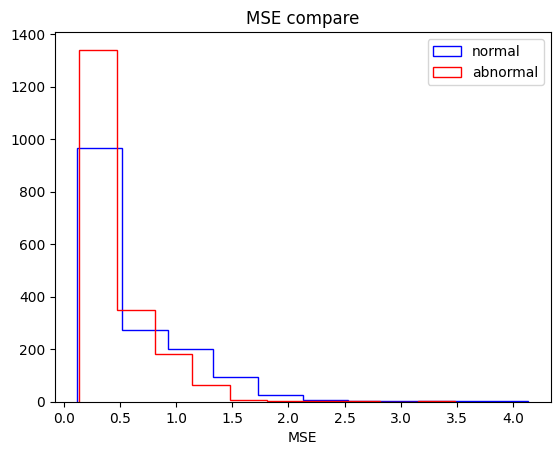

In [33]:
plt.title('MSE compare')
plt.hist(scored_train, bins=10, color='blue', histtype='step', label='normal')
plt.hist(scored_test, bins=10, color='red', histtype='step', label='abnormal')
plt.xlabel('MSE')
plt.legend()
plt.show()


In [34]:
print(error_df['true_class'].value_counts())


true_class
0.0    1052
1.0     900
Name: count, dtype: int64


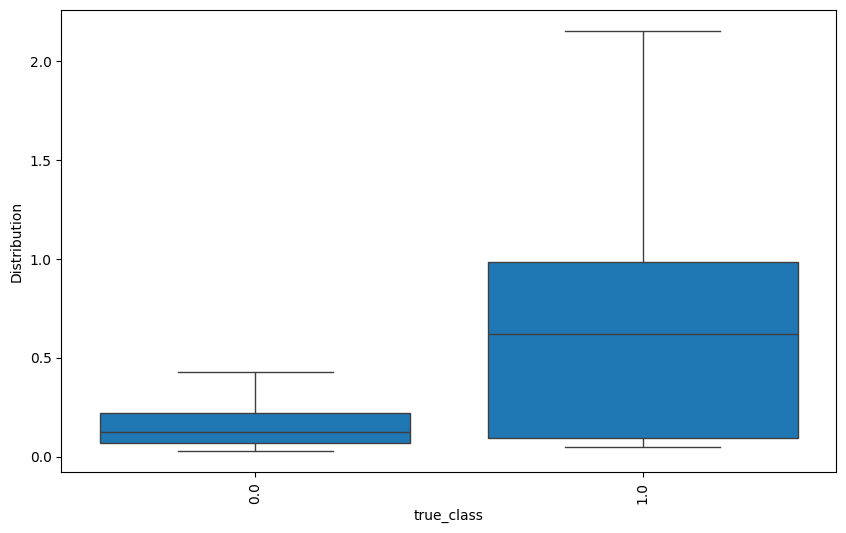

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False, saturation=1)
plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


In [40]:
threshold = 0.25

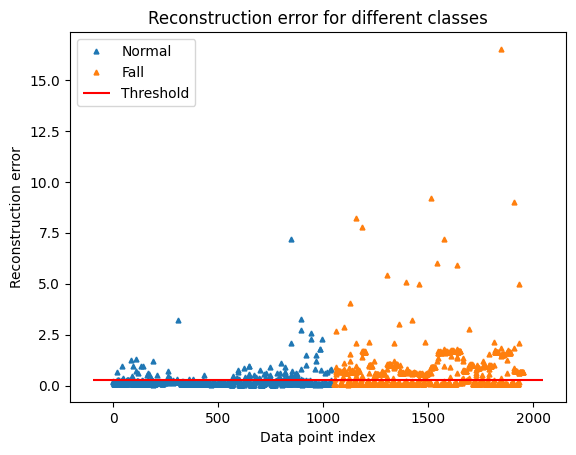

In [41]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label="Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

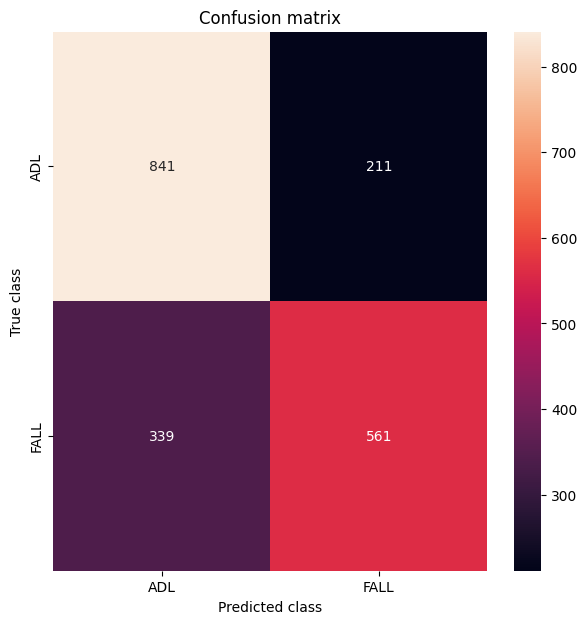

In [42]:
LABELS = ["ADL", "FALL"]
plt.figure(figsize=(7, 7))
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [43]:
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75      1052
         1.0       0.73      0.62      0.67       900

    accuracy                           0.72      1952
   macro avg       0.72      0.71      0.71      1952
weighted avg       0.72      0.72      0.72      1952

